## Imports

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")
sns.set_style("darkgrid")

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, AvgPool2D, Dropout, Flatten, Activation, ReLU
from keras.metrics import binary_accuracy, categorical_accuracy
from keras.utils import to_categorical
# from keras.utils.np_utils import to_categorical
import tensorflow as tf

## Helpers

In [147]:
def plot_history(train_data):
    labels = ['angry','disgust','fear','happy','sad','surprise','neutral']
    
    for data in train_data:
        history = data[0].history
        title = data[1]
        true = data[2]
        preds = data[3]
        
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
        fig.suptitle(title, fontsize=16, y=1.05, color='b')
        ax1.plot(history['accuracy'])
        ax1.plot(history['val_accuracy'])
        ax1.legend(['train', 'val'])
        ax1.set(title=f"train acc : {history['accuracy'][-1]}\nval acc : {history['val_accuracy'][-1]}", 
                  xlabel='epoch', ylabel='accuracy')

        ax2.plot(history['loss'])
        ax2.plot(history['val_loss'])
        ax2.legend(['train', 'val'])
        ax2.set(title=f"train loss : {history['loss'][-1]}\nval loss : {history['val_loss'][-1]}", 
                  xlabel='epoch', ylabel='loss')
        plt.show()
        print(classification_report(np.argmax(true, axis=1), np.argmax(preds, axis=1), target_names=labels))

## Load dataset

In [128]:
labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
data = pd.read_csv('data/FER2013/fer2013.csv')
X = []
for index, row in data.iterrows():
    image_pixels = np.asarray(list(row['pixels'].split(' ')), dtype=np.float64)
    image_pixels = image_pixels.reshape((48,48))
    X.append(image_pixels)
X = np.array(X)
X = np.expand_dims(X, 3)

y = to_categorical(data['emotion'].values)

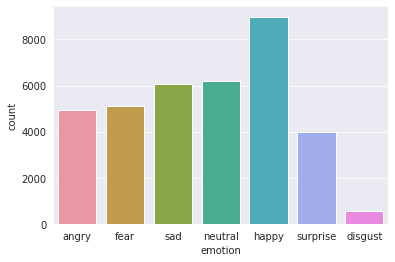

In [129]:
sns.countplot(data['emotion'].apply(lambda x : labels.get(x)))
plt.show()

From the above countplot graphic we can check that: 
- we have way more __*happy*__ samples than the rest of the other ones. 
- __*disgust*__ samples are almost 7 times less if compared to the category with more samples, __*happy*__.
- it is necessary to keep an eye on this imbalance on categories, once it may lead our model to bias towards happy labels and miss a lot of disgust samples.

## Models

####  Lenet

In [130]:
def build_lenet5():
    model = Sequential(name='LeNet-5')
    # Layer C1 (convolution) - 6 feature maps 28x28
    model.add(Conv2D(6, (5,5), strides=(1,1), input_shape=(48,48,1), name='C1', activation='relu'))
    
    # Layer S2 (sub-sampling) - 6 feature maps 14x14
    model.add(AvgPool2D(pool_size=(2,2), name='S2'))
    
    # Layer C3 (convolution) - 16 feature maps 10x10
    model.add(Conv2D(16, (5,5), strides=(1,1), name='C3', activation='relu'))
    
    # Layer S4 (sub-samlping) - 16 feature maps 5x5
    model.add(AvgPool2D(pool_size=(2,2), name='S4'))
    
    # Layer C5 (convolution) - 16 feature maps 10x10 - Flattened layer
    model.add(Conv2D(120, (4,4), strides=(1,1), name='C5', activation='relu'))
    model.add(Flatten(name='C5-Flat'))
    model.add(Dense(120, name='C5-Dense', activation='relu'))
    
    # Layer F6 - Full connection 84
    model.add(Dense(84, name='F6'))
    
    # Output layer
    model.add(Dense(7, activation='softmax', name='Output'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

#### Custom Model 1

In [131]:
def build_custom1():
    model = Sequential(name='LeNet-5')

    model.add(Conv2D(64, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(256, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(7, activation='softmax', name='Output'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

## Models tests

In [132]:
test_history = []

#### Test 1

- Model Lenet
- no pixel modification
- train/test ration = 0.8

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = build_lenet5()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=1)
preds = model.predict(X_test)
test_history.append((history, 'Model Lenet - vanilla', y_test, preds))

Train on 28709 samples, validate on 7178 samples
Epoch 1/15
28709/28709 [==============================] - 6s 219us/step - loss: 1.6174 - accuracy: 0.3837 - val_loss: 1.4760 - val_accuracy: 0.4246
Epoch 2/15
28709/28709 [==============================] - 6s 206us/step - loss: 1.3796 - accuracy: 0.4674 - val_loss: 1.4108 - val_accuracy: 0.4673
Epoch 3/15
28709/28709 [==============================] - 6s 207us/step - loss: 1.2544 - accuracy: 0.5207 - val_loss: 1.4048 - val_accuracy: 0.4606
Epoch 4/15
28709/28709 [==============================] - 6s 207us/step - loss: 1.1167 - accuracy: 0.5753 - val_loss: 1.4257 - val_accuracy: 0.4851
Epoch 5/15
28709/28709 [==============================] - 6s 207us/step - loss: 0.9497 - accuracy: 0.6468 - val_loss: 1.4771 - val_accuracy: 0.4798
Epoch 6/15
28709/28709 [==============================] - 6s 206us/step - loss: 0.7646 - accuracy: 0.7173 - val_loss: 1.6279 - val_accuracy: 0.4943
Epoch 7/15
28709/28709 [==============================] - 6s 20

#### Test 2

- Model Lenet
- pixel normalization : mean
- train/test ration = 0.8

In [150]:
mean = np.mean(X)
X_mean = X - mean
X_train, X_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)
model = build_lenet5()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=1)
preds = model.predict(X_test)
test_history.append((history, 'Model Lenet - pixel normalization (only mean pixel value)', y_test, preds))

Train on 28709 samples, validate on 7178 samples
Epoch 1/15
28709/28709 [==============================] - 6s 220us/step - loss: 1.7053 - accuracy: 0.3779 - val_loss: 1.4804 - val_accuracy: 0.4205
Epoch 2/15
28709/28709 [==============================] - 6s 210us/step - loss: 1.3911 - accuracy: 0.4684 - val_loss: 1.3901 - val_accuracy: 0.4728
Epoch 3/15
28709/28709 [==============================] - 6s 210us/step - loss: 1.2714 - accuracy: 0.5145 - val_loss: 1.3628 - val_accuracy: 0.4836
Epoch 4/15
28709/28709 [==============================] - 6s 210us/step - loss: 1.1471 - accuracy: 0.5686 - val_loss: 1.3489 - val_accuracy: 0.4980
Epoch 5/15
28709/28709 [==============================] - 6s 211us/step - loss: 1.0179 - accuracy: 0.6172 - val_loss: 1.3844 - val_accuracy: 0.5060
Epoch 6/15
28709/28709 [==============================] - 6s 209us/step - loss: 0.8751 - accuracy: 0.6749 - val_loss: 1.4815 - val_accuracy: 0.5050
Epoch 7/15
28709/28709 [==============================] - 6s 21

#### Test 3

- Model Lenet
- pixel normalization : mean + std
- train/test ration = 0.8

In [151]:
mean = np.mean(X)
std = np.std(X)
X_mean_std = (X - mean)/std
X_train, X_test, y_train, y_test = train_test_split(X_mean_std, y, test_size=0.2, random_state=42)
model = build_lenet5()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=1)
preds = model.predict(X_test)
test_history.append((history, 'Model Lenet - pixel normalization (mean + std pixel value)', y_test, preds))

Train on 28709 samples, validate on 7178 samples
Epoch 1/15
28709/28709 [==============================] - 6s 226us/step - loss: 1.5483 - accuracy: 0.3951 - val_loss: 1.3842 - val_accuracy: 0.4539
Epoch 2/15
28709/28709 [==============================] - 6s 213us/step - loss: 1.3123 - accuracy: 0.4966 - val_loss: 1.2627 - val_accuracy: 0.5099
Epoch 3/15
28709/28709 [==============================] - 6s 213us/step - loss: 1.1700 - accuracy: 0.5573 - val_loss: 1.2432 - val_accuracy: 0.5270
Epoch 4/15
28709/28709 [==============================] - 6s 213us/step - loss: 1.0260 - accuracy: 0.6123 - val_loss: 1.2676 - val_accuracy: 0.5340
Epoch 5/15
28709/28709 [==============================] - 6s 214us/step - loss: 0.8741 - accuracy: 0.6748 - val_loss: 1.3122 - val_accuracy: 0.5372
Epoch 6/15
28709/28709 [==============================] - 6s 213us/step - loss: 0.7024 - accuracy: 0.7394 - val_loss: 1.4672 - val_accuracy: 0.5396
Epoch 7/15
28709/28709 [==============================] - 6s 21

#### Test 4

- Model Custom 1
- pixel normalization : mean + std
- train/test ration = 0.8

In [152]:
mean = np.mean(X)
std = np.std(X)
X_mean_std = (X - mean)/std
X_train, X_test, y_train, y_test = train_test_split(X_mean_std, y, test_size=0.2, random_state=42)
model = build_custom1()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=1)
preds = model.predict(X_test)
test_history.append((history, 'Model Custom 1 - pixel normalization (mean + std pixel value)', y_test, preds))

Train on 28709 samples, validate on 7178 samples
Epoch 1/15
28709/28709 [==============================] - 30s 1ms/step - loss: 1.6101 - accuracy: 0.3623 - val_loss: 1.3997 - val_accuracy: 0.4588
Epoch 2/15
28709/28709 [==============================] - 30s 1ms/step - loss: 1.3234 - accuracy: 0.4902 - val_loss: 1.2242 - val_accuracy: 0.5302
Epoch 3/15
28709/28709 [==============================] - 30s 1ms/step - loss: 1.2101 - accuracy: 0.5343 - val_loss: 1.1723 - val_accuracy: 0.5589
Epoch 4/15
28709/28709 [==============================] - 30s 1ms/step - loss: 1.1449 - accuracy: 0.5641 - val_loss: 1.1477 - val_accuracy: 0.5678
Epoch 5/15
28709/28709 [==============================] - 30s 1ms/step - loss: 1.0851 - accuracy: 0.5846 - val_loss: 1.1333 - val_accuracy: 0.5694
Epoch 6/15
28709/28709 [==============================] - 30s 1ms/step - loss: 1.0174 - accuracy: 0.6091 - val_loss: 1.1149 - val_accuracy: 0.5828
Epoch 7/15
28709/28709 [==============================] - 30s 1ms/ste

## Results visualisation

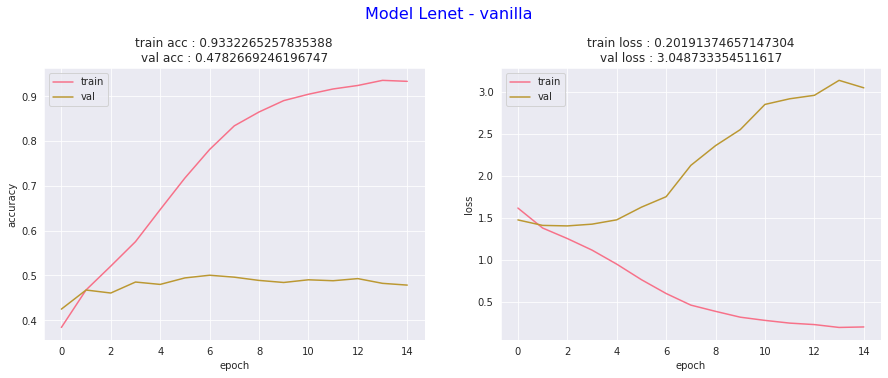

              precision    recall  f1-score   support

       angry       0.40      0.37      0.39       985
     disgust       0.56      0.38      0.45       102
        fear       0.34      0.40      0.37      1043
       happy       0.64      0.68      0.66      1765
         sad       0.34      0.35      0.35      1210
    surprise       0.68      0.60      0.63       795
     neutral       0.45      0.40      0.42      1278

    accuracy                           0.48      7178
   macro avg       0.49      0.45      0.47      7178
weighted avg       0.48      0.48      0.48      7178



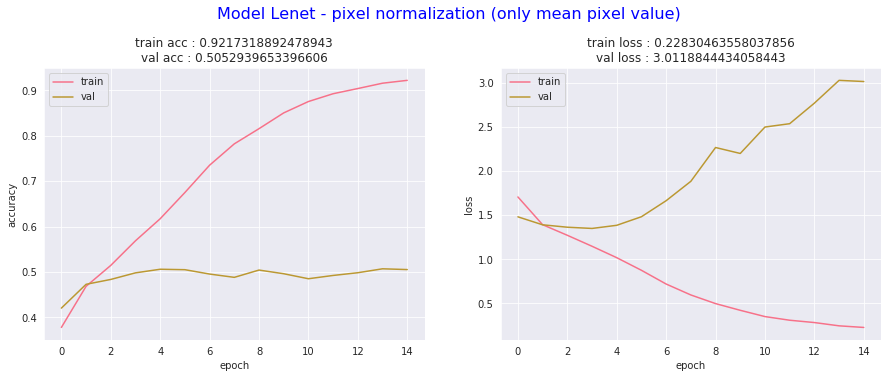

              precision    recall  f1-score   support

       angry       0.43      0.38      0.40       985
     disgust       0.54      0.40      0.46       102
        fear       0.42      0.35      0.38      1043
       happy       0.70      0.69      0.70      1765
         sad       0.37      0.44      0.40      1210
    surprise       0.64      0.63      0.63       795
     neutral       0.43      0.47      0.45      1278

    accuracy                           0.51      7178
   macro avg       0.50      0.48      0.49      7178
weighted avg       0.51      0.51      0.51      7178



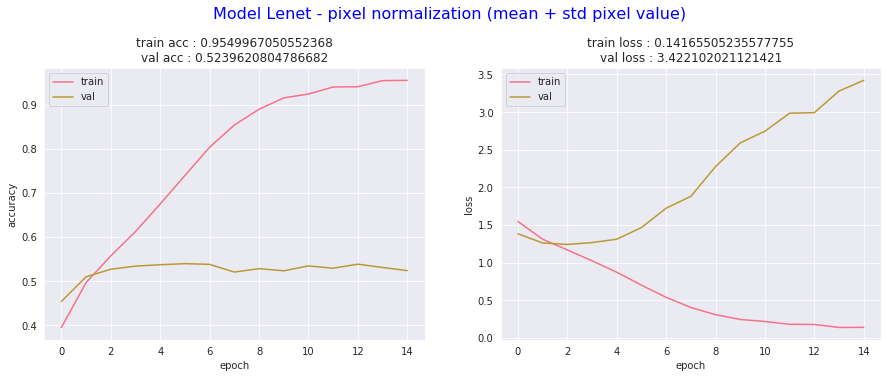

              precision    recall  f1-score   support

       angry       0.44      0.42      0.43       985
     disgust       0.48      0.53      0.50       102
        fear       0.41      0.38      0.39      1043
       happy       0.72      0.72      0.72      1765
         sad       0.37      0.41      0.39      1210
    surprise       0.69      0.65      0.67       795
     neutral       0.46      0.48      0.47      1278

    accuracy                           0.52      7178
   macro avg       0.51      0.51      0.51      7178
weighted avg       0.53      0.52      0.52      7178



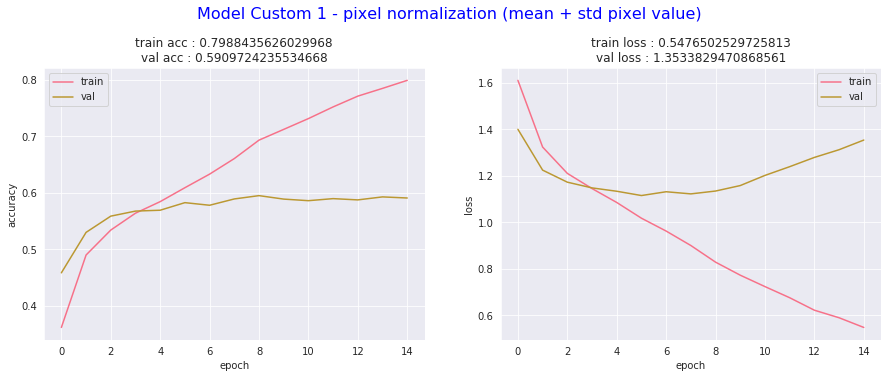

              precision    recall  f1-score   support

       angry       0.51      0.48      0.49       985
     disgust       0.63      0.46      0.53       102
        fear       0.48      0.42      0.45      1043
       happy       0.80      0.79      0.79      1765
         sad       0.43      0.50      0.47      1210
    surprise       0.72      0.70      0.71       795
     neutral       0.54      0.57      0.56      1278

    accuracy                           0.59      7178
   macro avg       0.59      0.56      0.57      7178
weighted avg       0.59      0.59      0.59      7178



In [156]:
plot_history(test_history)

In [154]:
# labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
img = cv2.imread('dummy7.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, dsize=(48,48), interpolation=cv2.INTER_CUBIC)
img = np.expand_dims(img,[0,3])

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
img.shape

In [ ]:
labels.get(np.argmax(model4.predict(img)))